In [1]:
import os 
import sys  # to interact with the python interpreter 
import requests # for http requests
import subprocess   # to spawn new processes, connect to their pipes, and obtain the return codes. Usefull for excuting shell commands from withing python
import shutil  # higher level interfacef for file operators. For copying and moving and deleting files and directories

# tracking events and erros in the application.
from logging import (
    getLogger, # creates or retrieves a logger object
    StreamHandler, 
    INFO
)


In [2]:
current_dir = os.getcwd()
current_dir

'/home/jerlshin/FieldOfInterest/My_Work/__PROJECTS__/GNN/Estimation_of_solubility_of_Chemical_Strucutres_SMILES_in_water'

In [3]:
print(f"Python Version: {sys.version}")
print(f"Command-line arguments: {sys.argv}")

# sys.exit(0)

Python Version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
Command-line arguments: ['/home/jerlshin/anaconda3/envs/gnn/lib/python3.12/site-packages/ipykernel_launcher.py', '--f=/home/jerlshin/.local/share/jupyter/runtime/kernel-v2-287620xW7K4TwoJxOD.json']


In [4]:
# for running a shell command
result = subprocess.run(
    ['ls', '-l'], capture_output=True, text=True
)

print(f"Command output: \n{result.stdout})")
print(f"Return Code: {result.returncode}")

Command output: 
total 12
drwxr-xr-x 4 jerlshin jerlshin 4096 Sep 12 22:09 esol
-rw-r--r-- 1 jerlshin jerlshin 4426 Sep 12 22:32 MoleculeNet_torch_geometric_MoleculeNet.ipynb
)
Return Code: 0


In [7]:
# shutil.copy(source, destination)
# os.remove(destination)

### Dataset

- From MoleculeNet collection

#### ESOL

Dataset consisting of water solubility data for 1128 compounds. The dataset has used to train models that estimate solubility directly from the chemical strucutres.

#### SMILS

Encoded in SMILS strings.

In [8]:
"""Solute + Solvent ===> Solution"""

'Solute + Solvent ===> Solution'

In [34]:
import torch
import rdkit
from torch_geometric.datasets import MoleculeNet

from rdkit import Chem 
from rdkit.Chem.Draw import IPythonConsole

from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp 

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [1]:
data = MoleculeNet(root=".", name="ESOL")

/home/jerlshin/anaconda3/envs/gnn/lib/python3.12/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.

In [8]:
data, len(data), type(data)

(ESOL(1128), 1128, torch_geometric.datasets.molecule_net.MoleculeNet)

In [4]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [11]:
# [num_nodes, num_node_features]
data[0].x  # Train 

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [13]:
# edges in sparse COO format
# [2, num_edges]

data[0].edge_index.t()

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

One label for the whole graph

In [14]:
data[0].y  # target # predictions based on the graph level

tensor([[-0.7700]])

In [15]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

In [22]:
type(data[0]), data[0]

(torch_geometric.data.data.Data,
 Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1]))

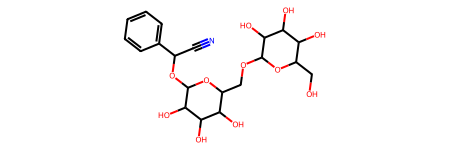

In [23]:
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [24]:
type(molecule)

rdkit.Chem.rdchem.Mol

### GNN

In [26]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # init parent
        super(GCN, self).__init__()
        
        torch.manual_seed(42)
        
        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size) # size of input sample ---> size of embedding
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        
        # output layer 
        self.out = Linear(embedding_size * 2, 1) # we need just one ouput. Solvability of molecule in water
    
    def forward(self, x, edge_index, batch_index):
        # first conv
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        
        # next layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        
        hidden = F.tanh(self.conv2(hidden, edge_index))
        hidden = F.tanh(self.conv3(hidden, edge_index))
        
        # global pooling
        hidden = torch.cat(
            [
                gmp(hidden, batch_index),
                gap(hidden, batch_index)
            ], dim=1
        )
        
        out = self.out(hidden)
        return out, hidden

model = GCN()
print(model)

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [32]:
for p in model.parameters():
    print(p)
    print(p.numel())  # num of elements (numel) to get the total number of elements in the tensor
    break

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)
64


In [29]:
sum(p.numel() for p in model.parameters())

13249

### Training

In [36]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device=device)

# wrap data in the data_loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64


loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


cpu


In [40]:
type(iter(loader))

torch.utils.data.dataloader._SingleProcessDataLoaderIter

In [41]:
def train(data):
    for batch in loader:
        batch.to(device)
        optimizer.zero_grad()
        pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        
        optimizer.step()
    return loss, embedding

print("Starting....")

losses = []

for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss {loss}")
        

Starting....
Epoch 0 | Train Loss 13.998751640319824
Epoch 100 | Train Loss 1.3565469980239868
Epoch 200 | Train Loss 0.7664408087730408
Epoch 300 | Train Loss 0.23416882753372192
Epoch 400 | Train Loss 0.3954941928386688
Epoch 500 | Train Loss 1.107529878616333
Epoch 600 | Train Loss 0.3271014094352722
Epoch 700 | Train Loss 0.07140111923217773
Epoch 800 | Train Loss 0.10998234897851944
Epoch 900 | Train Loss 0.09492036700248718
Epoch 1000 | Train Loss 0.1793118566274643
Epoch 1100 | Train Loss 0.06232843175530434
Epoch 1200 | Train Loss 0.03567661717534065
Epoch 1300 | Train Loss 0.03088643215596676
Epoch 1400 | Train Loss 0.024380618706345558
Epoch 1500 | Train Loss 0.02507040835916996
Epoch 1600 | Train Loss 0.4377221167087555
Epoch 1700 | Train Loss 0.0773453414440155
Epoch 1800 | Train Loss 0.10844042152166367
Epoch 1900 | Train Loss 0.03846874460577965


In [46]:
torch.save(model, 'model.pth')

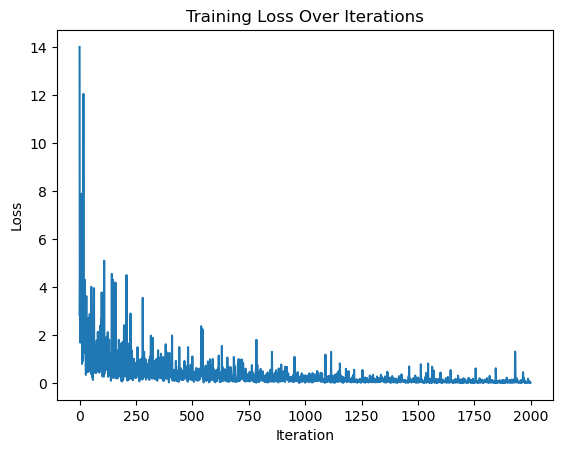

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i, _ in enumerate(losses_float)] 
sns.lineplot(x=loss_indices, y=losses_float)

# Display the plot
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.show()


In [44]:
import pandas as pd 

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-2.570,-2.346094
1,-1.470,-1.287253
2,-5.410,-3.093911
3,0.610,-0.404179
4,-5.230,-4.248174
...,...,...
59,-1.920,-1.902231
60,-4.230,-3.857799
61,-4.554,-2.876216
62,-1.960,-1.672133


<Axes: xlabel='y_real', ylabel='y_pred'>

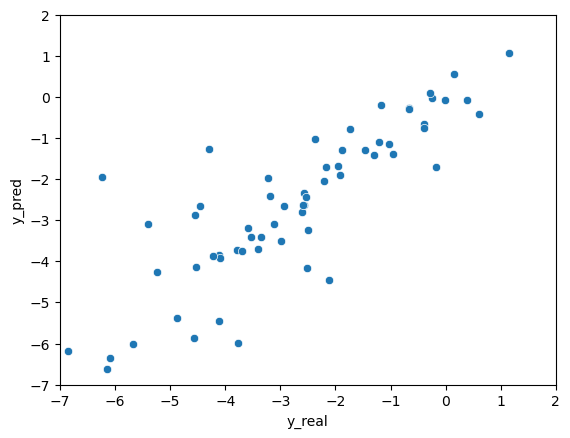

In [49]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt